In [3]:
import numpy as np
def DFT_slow(x):
    """Compute the discrete Fourier Transform of the 1D array x"""
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    n = np.arange(N)
    k = n.reshape((N, 1))
    M = np.exp(-2j * np.pi * k * n / N)
    return np.dot(M, x)

In [7]:
x = np.random.random(1024)
np.allclose(DFT_slow(x), np.fft.fft(x))

True

In [8]:
x

array([0.57561784, 0.50183257, 0.24715833, ..., 0.69534383, 0.68020248,
       0.00743376])

In [3]:
%timeit DFT_slow(x)
%timeit np.fft.fft(x)

98 ms ± 8.57 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
23.1 µs ± 495 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [6]:
def FFT(x):
    """A recursive implementation of the 1D Cooley-Tukey FFT"""
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    
    if N % 2 > 0:
        raise ValueError("size of x must be a power of 2")
    elif N <= 32:  # this cutoff should be optimized
        return DFT_slow(x)
    else:
        X_even = FFT(x[::2])
        X_odd = FFT(x[1::2])
        factor = np.exp(-2j * np.pi * np.arange(N) / N)
        return np.concatenate([X_even + factor[:N / 2] * X_odd,
                               X_even + factor[N / 2:] * X_odd])

In [7]:
x = np.random.random(1024)
np.allclose(FFT(x), np.fft.fft(x))

TypeError: slice indices must be integers or None or have an __index__ method

In [8]:
%timeit DFT_slow(x)
%timeit FFT(x)
%timeit np.fft.fft(x)

92.2 ms ± 1.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


TypeError: slice indices must be integers or None or have an __index__ method

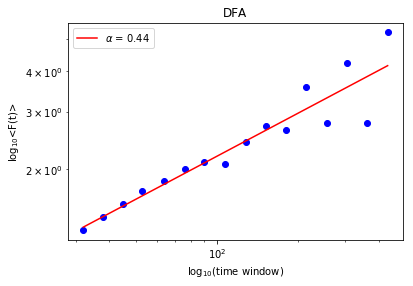

[ 32  38  45  53  64  76  90 107 128 152 181 215 256 304 362 430]
[1.30293349 1.42963517 1.56827995 1.71211036 1.84294896 2.0046261
 2.10312977 2.08330434 2.42794511 2.7063569  2.63923246 3.56571685
 2.7776375  4.22887234 2.77941533 5.24838399]
DFA exponent: 0.43803718746652587


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss

# detrended fluctuation analysis

def calc_rms(x, scale):
    """
    windowed Root Mean Square (RMS) with linear detrending.
    
    Args:
    -----
      *x* : numpy.array
        one dimensional data vector
      *scale* : int
        length of the window in which RMS will be calculaed
    Returns:
    --------
      *rms* : numpy.array
        RMS data in each window with length len(x)//scale
    """
    # making an array with data divided in windows
    shape = (x.shape[0]//scale, scale)
    X = np.lib.stride_tricks.as_strided(x,shape=shape)
    # vector of x-axis points to regression
    scale_ax = np.arange(scale)
    rms = np.zeros(X.shape[0])
    for e, xcut in enumerate(X):
        coeff = np.polyfit(scale_ax, xcut, 1)
        xfit = np.polyval(coeff, scale_ax)
        # detrending and computing RMS of each window
        rms[e] = np.sqrt(np.mean((xcut-xfit)**2))
    return rms

def dfa(x, scale_lim=[5,9], scale_dens=0.25, show=False):
    """
    Detrended Fluctuation Analysis - measures power law scaling coefficient
    of the given signal *x*.
    More details about the algorithm you can find e.g. here:
    Hardstone, R. et al. Detrended fluctuation analysis: A scale-free 
    view on neuronal oscillations, (2012).
    Args:
    -----
      *x* : numpy.array
        one dimensional data vector
      *scale_lim* = [5,9] : list of length 2 
        boundaries of the scale, where scale means windows among which RMS
        is calculated. Numbers from list are exponents of 2 to the power
        of X, eg. [5,9] is in fact [2**5, 2**9].
        You can think of it that if your signal is sampled with F_s = 128 Hz,
        then the lowest considered scale would be 2**5/128 = 32/128 = 0.25,
        so 250 ms.
      *scale_dens* = 0.25 : float
        density of scale divisions, eg. for 0.25 we get 2**[5, 5.25, 5.5, ... ] 
      *show* = False
        if True it shows matplotlib log-log plot.
    Returns:
    --------
      *scales* : numpy.array
        vector of scales (x axis)
      *fluct* : numpy.array
        fluctuation function values (y axis)
      *alpha* : float
        estimation of DFA exponent
    """
    # cumulative sum of data with substracted offset
    y = np.cumsum(x - np.mean(x))
    scales = (2**np.arange(scale_lim[0], scale_lim[1], scale_dens)).astype(np.int)
    fluct = np.zeros(len(scales))
    # computing RMS for each window
    for e, sc in enumerate(scales):
        fluct[e] = np.mean(np.sqrt(calc_rms(y, sc)**2))
    # fitting a line to rms data
    coeff = np.polyfit(np.log2(scales), np.log2(fluct), 1)
    if show:
        fluctfit = 2**np.polyval(coeff,np.log2(scales))
        plt.loglog(scales, fluct, 'bo')
        plt.loglog(scales, fluctfit, 'r', label=r'$\alpha$ = %0.2f'%coeff[0])
        plt.title('DFA')
        plt.xlabel(r'$\log_{10}$(time window)')
        plt.ylabel(r'$\log_{10}$<F(t)>')
        plt.legend()
        plt.show()
    return scales, fluct, coeff[0]


if __name__=='__main__':
    n = 1000
    x = np.random.randn(n)
    # computing DFA of signal envelope
    x = np.abs(ss.hilbert(x))
    scales, fluct, alpha = dfa(x, show=1)
    print(scales)
    print(fluct)
print("DFA exponent: {}".format(alpha))

In [3]:
#-*-coding: utf-8-*-
"""
Created on Thu Dec  4 20:30:25 2014
@author: zlfccnu
"""

import numpy as np
import pandas as pd
import matplotlib as mp
import scipy as sy
import sympy as syy
from igraph import *
import random
import itertools
import statsmodels.formula.api as sm

def F2_DFA(x,nVec,sampleNum,detrendOrder):
    y=x-x.mean()
    y=y.cumsum()
    f2_DFA=pd.DataFrame()
    for n in nVec:
        f2_DFA_Tmp=np.array(np.zeros(sampleNum))
        startIndex=random.sample(range(len(y)-n+1),sampleNum)
        for i in range(sampleNum):
            fit_x=range(startIndex[i],(startIndex[i]+n-1))
            fit_y=y[startIndex[i]:(startIndex[i]+n-1)]
            DFA_coef=np.polyfit(fit_x,fit_y,detrendOrder)
            fitDFA=np.poly1d(DFA_coef)
            f2_DFA_Tmp[i]=np.mean(fit_y-fitDFA(fit_x))
            f2_DFA[str(n)]=f2_DFA_Tmp

DeprecationWarning: To avoid name collision with the igraph project, this visualization library has been renamed to 'jgraph'. Please upgrade when convenient.

In [15]:
import numpy as np
import math
from scipy import stats
"""
PUCK Analysis
Parameters :  M = order of SMA, usually set from 8 to 64. M has more effect than k.
              k = order of OMA, smaller than M . inchapter 5 k=5;
"""

def PUCK(data, size_data, M, k):
    N = size_data
    
    # estimate OMA
    p = np.zeros(N+M+1,1)
    
    # define MA constant
    w = np.zeros(k,1)
    for n in range (1,k):
        w[n] = np.exp(-0.3*n)
    for t in range (1,N+M+1):
        for n in range (1,k):
            p[t] = p[t]+(ar_coeffs(n+1)*data(t+n-1,1))
            
    #estimate SMA
    pm = np.zeros(N,1)
    for t in range (1,N):
        for n in range (1,M):
            pm[t]= pm[t]+(p(t+n-1,1))
        pm[t] = pm[t]/M
        
    #estimate time different measures
    p = p(M+1 in N+M+1)
    pm = pm
    time = np.zeros(N,1)
    interval = zeros(N,1)
    for t in range (1,N):
        time[t] = p(t+1)-p(t)
    for t in range (1,N):
        interval[t] = p(t)-pm(t)
    
    centroid = [np.mean(time), np.mean(interval)]
    avgdistance = np.mean(np.sqrt(np.power(np.abs(time - centroid(1,1)),2)+np.power(np.abs(interval - centroid (1,2)),2)))
    distance = np.sqrt(np.power(np.bs(time - centroid(1,1)),2) + np.power(np.abs(interval-centroid(1,2)),2))
    weight = 1
    #slope = ((time.*weight')'*interval)/((time.*weight')'*time)
    slope = stats.theilslopes(y, x, 0.90) #theilsen regression
    
    R = corrcoef(time,interval)
    correlation = R(1,2)
    RRpredict = p(N) + correlation*time(N)
    
    x1 = time(1)
    y1 = slope*time(1)
    
    x2 = time
    y2 = slope*time(N)
    slopeAngle = math.degrees(math.atan((y1-y2)/(x2-x1))) #inverse tan in degree
    matrix1 = np.array([[math.degrees(math.cos(slopeAngle)), -math.degrees(math.sin(slopeAngle))],[math.degrees(math.sin(slopeAngle)), math.degrees(math.cos(slopeAngle))]])
    matrix2 = np.array([[np.transpose(time(M+1 in N-1))] , [np.transpose(interval(M+1 in N-1))]])
    rot_matrix = np.matmul(matrix1,matrix2)
    new_interval = rot_matrix[1]
    new_time = rot_matrix[2]
    SSD1 = np.std(new_time)
    SSD2 = np.std(new_interval)
    return SSD1,SSD2
    
if __name__=='__main__':
    n = 1000
    x = np.random.randn(n)
    PUCK(x,n,16,5)

TypeError: data type not understood

In [26]:
import matplotlib.pyplot as plt
import plotly
import plotly.plotly as py
plotly.tools.set_credentials_file(username='ArifulFurqon', api_key='zHRxWpsKgLxci0gNGXtQ')
import numpy as np
# Learn about API authentication here: https://plot.ly/python/getting-started
# Find your api_key here: https://plot.ly/settings/api

Fs = 150.0;  # sampling rate
Ts = 1.0/Fs; # sampling interval
t = np.arange(0,1,Ts) # time vector

ff = 5;   # frequency of the signal
y = np.sin(2*np.pi*ff*t)

n = len(y) # length of the signal
k = np.arange(n)
T = n/Fs
frq = k/T # two sides frequency range
frq = frq[range(n//2)] # one side frequency range

Y = np.fft.fft(y)/n # fft computing and normalization
Y = Y[range(n//2)]

fig, ax = plt.subplots(2, 1)
ax[0].plot(t,y)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Amplitude')
ax[1].plot(frq,abs(Y),'r') # plotting the spectrum
ax[1].set_xlabel('Freq (Hz)')
ax[1].set_ylabel('|Y(freq)|')

plot_url = py.plot_mpl(fig, filename='mpl-basic-fft')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~ArifulFurqon/0 or inside your plot.ly account where it is named 'mpl-basic-fft'


In [11]:
a = np.array([[1, 0],
              [0, 1]])
b = np.array([[4, 1], 
              [2, 2]])
np.matmul(a, b)

array([[4, 1],
       [2, 2]])